In [119]:
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import missingno as msno
import statsmodels.api as stat

In [120]:
base_url = 'C:/Users/rimo/Documents/Python/web/'
product = pd.read_csv(base_url+'products.csv') #read the product csv file
copurchase = pd.read_csv(base_url+'copurchase.csv') #read the product csv file

In [10]:
#data summary product
pandas_profiling.ProfileReport(product)

Number of variables,7
Number of observations,259167
Total Missing (%),0.0%
Total size in memory,13.8 MiB
Average record size in memory,56.0 B
Numeric,4
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,1


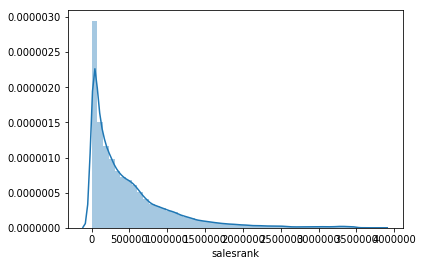

In [12]:
sns.distplot(product.salesrank)
#sns.kdeplot(product.salesrank, shade=True);
#sns.distplot(product.salesrank, hist=False, rug=True);

In [11]:
#data summary co-purchase
pandas_profiling.ProfileReport(copurchase)

Number of variables,2
Number of observations,1234870
Total Missing (%),0.0%
Total size in memory,18.8 MiB
Average record size in memory,16.0 B
Numeric,2
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [195]:
#drop salesrank with negative values
product = product[product['salesrank'] != -1]
product.shape

(187829, 10)

In [122]:
#keep only book categories
product = product[product.group == "Book"]
product.shape

(187829, 7)

In [123]:
product.head()

,id,title,group,salesrank,review_cnt,downloads,rating
0,1,Patterns of Preaching: A Sermon Sampler,Book,396585.0,2,2,5.0
1,2,Candlemas: Feast of Flames,Book,168596.0,12,12,4.5
2,3,World War II Allied Fighter Planes Trading Cards,Book,1270652.0,1,1,5.0
3,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,631289.0,1,1,4.0
4,5,Prayers That Avail Much for Business: Executive,Book,455160.0,0,0,0.0


In [124]:
#keep only book ids in copurchase
copurchase = copurchase[copurchase.Source.isin(product.id.values)]
copurchase.shape

(884763, 2)

In [125]:
#keep only book ids in copurchase
copurchase = copurchase[copurchase.Target.isin(product.id.values)]
copurchase.shape

(636680, 2)

In [126]:
#calculate density
edges = copurchase.shape[0]
nodes = len(set(np.append(copurchase.Source,copurchase.Target)))
density = edges/(nodes*(nodes-1))
print (density)

1.841229067865028e-05


In [24]:
#grouped_data = copurchase.groupby(['Source'])
#for g, grp in grouped_data:
#    print (grp)

In [127]:
#calculate outdegree
#out_degree=copurchase.groupby(['Source']).agg({'Target': ['count']})
#out_degree.head()
#out_degree.rename(columns={'Source': 'id', 'count': 'out-degree'}, inplace=True)
out_degree=copurchase.groupby(['Source']).size().reset_index(name='out-degree')
out_degree.rename(columns={'Source': 'id',}, inplace=True)
out_degree.head()

,id,out-degree
0,1,4
1,2,3
2,3,5
3,4,3
4,5,4


In [128]:
#calculate indegree
#in_degree=copurchase.groupby(['Target']).agg({'Source': ['count']})
#in_degree.head()
in_degree=copurchase.groupby(['Target']).size().reset_index(name='in-degree')
in_degree.rename(columns={'Target': 'id'}, inplace=True)
in_degree.head()

,id,in-degree
0,2,1
1,4,19
2,5,45
3,6,70
4,8,201


In [162]:
#find the neighbors
neighbors = {}
for i in copurchase.itertuples():
    source = i[1]
    target = i[2]
    #target to source
    if target in neighbors: neighbors[target].append(source)
    else: neighbors[target] = [source]

In [193]:
#neighbors[8]

In [163]:
#defining method to calculate neighbor means for ratings, review count, salesrank
def calculateMean(product,lt):
    neighborRatings = []
    neighborSalesranks = []
    neighborReviews = []
    for i in lt:
        neighborRatings.append(product.loc[product['id']==i,'rating'].values[0])
        neighborReviews.append(product.loc[product['id']==i,'review_cnt'].values[0])
        neighborSalesranks.append(product.loc[product['id']==i, 'salesrank'].values[0])
    return np.mean(neighborRatings), np.mean(neighborSalesranks), np.mean(neighborReviews)

In [164]:
#calculate neighbor means
product['mnn'] = 0.0
product['mnr'] = 0.0
product['mns'] = 0.0
#count = 0
for i in product.itertuples():
    #count+=1
    #if count%10000==0: print ('done')
    if i[1] in neighbors.keys(): mnn, mns, mnr = calculateMean(product,neighbors[i[1]])
    product.set_value(i[0], 'mnn', mnn)
    product.set_value(i[0], 'mns', mns)
    product.set_value(i[0], 'mnr', mnr)

C:\Users\rimo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
C:\Users\rimo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\rimo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


In [165]:
#product.head()

In [194]:
#exporting to csv for future computations
product.to_csv('product~new.csv', index=False)

In [181]:
products = pd.read_csv(base_url+'product~new.csv') #read the product csv file

In [182]:
#renaming for readability
products.rename(columns={'mnn': 'mean_rating', 'mnr': 'mean_reviewcount', 'mns': "mean_salesrank"}, inplace=True)

In [183]:
products.shape

(187829, 11)

In [184]:
#inner join out_degree and products
products = pd.merge(products, out_degree, on='id', how='inner')
products.shape

(182859, 12)

In [185]:
#inner join in_degree and products
products = pd.merge(products, in_degree, on='id', how='inner')
products.shape

(171586, 13)

In [186]:
#products.apply(pd.to_numeric, errors='ignore', downcast='float')
products.rename(columns={'in-degree': 'indegr'}, inplace=True)
products.rename(columns={'out-degree': 'outdegr'}, inplace=True)

In [187]:
products.shape

(171586, 13)

In [177]:
#products = products[products.mean_rating != 0]
#products = products[products.mean_reviewcount != 0]
#products = products[products.mean_salesrank != 0]

In [188]:
products.head()

,Unnamed: 0,id,title,group,salesrank,review_cnt,downloads,rating,mean_rating,mean_reviewcount,mean_salesrank,outdegr,indegr
0,1,2,Candlemas: Feast of Flames,Book,168596.0,12,12,4.5,5.000000,2.000000,396585.000000,3,1
1,3,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,631289.0,1,1,4.0,3.815789,7.263158,430560.210526,3,19
2,4,5,Prayers That Avail Much for Business: Executive,Book,455160.0,0,0,0.0,2.944444,12.555556,644094.177778,4,45
3,5,6,How the Other Half Lives: Studies Among the Te...,Book,188784.0,17,17,4.0,3.228571,6.871429,677168.914286,4,70
4,7,8,Losing Matt Shepard,Book,277409.0,15,15,4.5,3.037313,15.213930,660123.308458,3,201


In [189]:
#poisson regression
model = stat.formula.glm("salesrank ~ review_cnt + rating + mean_rating + mean_reviewcount + mean_salesrank + outdegr + indegr",
                       family=stat.families.Poisson(), data=products).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              salesrank   No. Observations:               171586
Model:                            GLM   Df Residuals:                   171578
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -3.4634e+10
Date:                Tue, 27 Feb 2018   Deviance:                   6.9266e+10
Time:                        15:28:15   Pearson chi2:                 3.68e+13
No. Iterations:                     8                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           13.8219   1.48e-05   9.31e+05      0.000      13.822      13.822
review_cnt          -0.0031   1.47

In [190]:
#calculate multiplicity
print (np.exp(model.params)-1)

Intercept           1.006406e+06
review_cnt         -3.142164e-03
rating             -1.530755e-01
mean_rating        -8.500934e-04
mean_reviewcount   -2.909107e-05
mean_salesrank      3.411031e-10
outdegr             1.675324e-03
indegr              2.313136e-04
dtype: float64
